## BBM 409 - Programming Assignment 4

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

# **Gökdeniz Şimşek - 2210356067**

## Understanding LSTM's with Sentiment Analysis (100 points)

### 1. Data Loading and Exploration (5 points)
* Brief overview of the task.

  - The task is to build a sentiment analysis model using Long Short-Term Memory (LSTM) networks, focusing on the ability of LSTMs to capture sequential dependencies in text data. The objective is to classify movie reviews from the IMDB dataset as either positive or negative, demonstrating the LSTM’s effectiveness in understanding context and long-term relationships in textual data. This process involves data preprocessing, embedding creation, LSTM implementation, and performance evaluation.
* Description of the dataset used for analysis.

  - The IMDB Movie Reviews dataset is a labeled collection of 10,000 reviews, evenly divided between positive (label 1) and negative (label 0) sentiments, ensuring balanced classes. Each review consists of textual content and a corresponding sentiment label. The dataset is provided in CSV format, making it easy to load and manipulate using pandas. Its balanced nature and real-world relevance make it a standard benchmark for sentiment analysis tasks. Exploratory analysis of this dataset will help identify key characteristics, such as the distribution of review lengths and the presence of any missing or noisy data, ensuring that the input is optimized for model training.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from bs4 import BeautifulSoup
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Load the data into pandas a dataframe
data = pd.read_csv("subset10000_IMDB_Dataset.csv")

# Represent the sentiments in a meaningful numerical form
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Check the first few rows
print(data.head())

                                              review  sentiment
0  Starts really well, nice intro and build up fo...          0
1  Terrific movie: If you did not watch yet, you ...          1
2  I've seen hundreds of silent movies. Some will...          1
3  i had been looking for this film for so long b...          1
4  Good: Engaging cinematic firefights, great pre...          1


In [ ]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
print(f"Dataset Size: {data.shape}")
print("Features:", data.columns)
print("Target Variable Distribution:\n", data['sentiment'].value_counts())
print("Summary Statistics:\n", data.describe())

## Check for any missing values and handle them if necessary.
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Drop rows with missing values if any exist
if missing_values.any():
    data = data.dropna()
    print(f"Dataset Size After Dropping Missing Values: {data.shape}")

Dataset Size: (10000, 2)
Features: Index(['review', 'sentiment'], dtype='object')
Target Variable Distribution:
 sentiment
0    5000
1    5000
Name: count, dtype: int64
Summary Statistics:
           sentiment
count  10000.000000
mean       0.500000
std        0.500025
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Missing Values:
 review       0
sentiment    0
dtype: int64


### 2. Preprocessing the Data (10 points)

In [ ]:
# An example function for prepocess the texts and create the tokens, you can improve it to clean the texts more accurately

def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convert to lower case
    text = text.lower()

    # Clean special characters (remove everything except letters and spaces)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Leave a space, remove other characters

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [ ]:
# Add a tokens column to the dataframe to store preprocessed tokens
# Build the vocabulary using the tokens
# Assign indices to each token in the vocabulary
# Reserve 0 for padding

# Add tokens column for each comment in DataFrame
data['tokens'] = data['review'].apply(preprocess_text)

# Combine all tokens and count their frequencies
all_words = {token for tokens in data['tokens'] for token in tokens}
all_words = sorted(all_words)

# Assign an index to each word (reserving 0 for padding)
vocabulary = {word: idx + 1 for idx, word in enumerate(all_words)}
vocab_size = len(vocabulary)
print(f"Vocabulary Size: {vocab_size}")

<ipython-input-8-04586beb4c8f>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Vocabulary Size: 46197


In [ ]:
print(vocabulary)

{'aa': 1, 'aaa': 2, 'aaaaaaahhhhhhggg': 3, 'aaaaatch': 4, 'aaaarrgh': 5, 'aaaggghhhhhhh': 6, 'aaam': 7, 'aab': 8, 'aag': 9, 'aaghh': 10, 'aahhh': 11, 'aajala': 12, 'aakash': 13, 'aaker': 14, 'aalcc': 15, 'aaliyah': 16, 'aames': 17, 'aamir': 18, 'aamr': 19, 'aardman': 20, 'aardvark': 21, 'aargh': 22, 'aaron': 23, 'aarp': 24, 'aasman': 25, 'aaton': 26, 'aawip': 27, 'ab': 28, 'aback': 29, 'abagail': 30, 'abandon': 31, 'abandoned': 32, 'abandoning': 33, 'abandonment': 34, 'abandonof': 35, 'abba': 36, 'abbas': 37, 'abbe': 38, 'abbey': 39, 'abbie': 40, 'abbot': 41, 'abbott': 42, 'abbreviated': 43, 'abc': 44, 'abdic': 45, 'abdomen': 46, 'abdominal': 47, 'abduct': 48, 'abducted': 49, 'abductee': 50, 'abduction': 51, 'abductor': 52, 'abducts': 53, 'abdul': 54, 'abdullah': 55, 'abe': 56, 'abed': 57, 'abel': 58, 'abemethie': 59, 'abercrombie': 60, 'aberdeen': 61, 'abernathie': 62, 'abernethie': 63, 'aberration': 64, 'abetted': 65, 'abhi': 66, 'abhijeet': 67, 'abhimaan': 68, 'abhishek': 69, 'abhor

In [ ]:
# Calculate the length of each review from the tokenized version
# Display statistical details about review lengths
# Decide padding length considering these stats
# Remember we don't want padded zeros to overcome meaningful information in the sequence

# Calculate token length of each comment
data['review_length'] = data['tokens'].apply(len)

# Print length statistics
print(data['review_length'].describe())

# Select padding length (e.g. use 95th percentile)
max_len = int(data['review_length'].quantile(0.95))  # 95. yüzdelik dilimi
print(f"Padding Length: {max_len}")

count    10000.000000
mean       117.764100
std         89.209761
min          4.000000
25%         63.000000
50%         88.000000
75%        145.000000
max        809.000000
Name: review_length, dtype: float64
Padding Length: 305


In [ ]:
# Convert review tokens to indices and add an indices column to the dataframe to store
# Represent each token in the dataset with its corresponding index from the vocabulary
# Ensure all sequences have the same length by padding shorter sequences with zeros
# Pad the token indices version of review sequences

# Match each token with the index in the vocab
data['indices'] = data['tokens'].apply(lambda x: [vocabulary.get(word, 0) for word in x])

# Function for padding operation
def pad_sequence(seq, max_len):
    return seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

# Add an padded_indices column to store padded sequences
data['padded_indices'] = data['indices'].apply(lambda x: pad_sequence(x, max_len))


In [ ]:
print(data[['review', 'tokens', 'indices', 'padded_indices']].head())

                                              review  \
0  Starts really well, nice intro and build up fo...   
1  Terrific movie: If you did not watch yet, you ...   
2  I've seen hundreds of silent movies. Some will...   
3  i had been looking for this film for so long b...   
4  Good: Engaging cinematic firefights, great pre...   

                                              tokens  \
0  [start, really, well, nice, intro, build, main...   
1  [terrific, movie, watch, yet, must, watch, gee...   
2  [seen, hundred, silent, movie, always, classic...   
3  [looking, film, long, found, seen, younger, lo...   
4  [good, engaging, cinematic, firefights, great,...   

                                             indices  \
0  [38807, 33040, 44846, 27914, 20989, 5393, 2477...   
1  [40829, 27064, 44645, 45851, 27315, 44645, 164...   
2  [36131, 19580, 37110, 27064, 1159, 7279, 28218...   
3  [24146, 14879, 24108, 15616, 36131, 45909, 242...   
4  [17088, 13161, 7154, 14996, 17376, 31622, 4

### 3. Visualzing Word Vectors (15 points)

In [ ]:
# Load the FastText word vectors
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

[==================================================] 100.0% 958.5/958.4MB downloaded
FastText model loaded.


In [ ]:
# Check out for Out-of-Vocaublary (OOV) words
# See how many words in your created vocaublary are not presented in fasttext-vectors
# Make comments on how OOV words can effect your model performance

# Check for Out-of-Vocabulary (OOV) words
oov_words = [word for word in vocabulary if word not in fasttext_vectors]
print(f"Number of OOV words: {len(oov_words)}")

# You can display some OOV words
print("Some OOV words:", oov_words[:10])

Number of OOV words: 11369
Some OOV words: ['aaaaaaahhhhhhggg', 'aaaaatch', 'aaaarrgh', 'aaaggghhhhhhh', 'aaam', 'aaghh', 'aajala', 'aakash', 'aaker', 'aalcc']


In [ ]:
# Visualize word vectors to understand how they work.
# Start by choosing a manageable number of words from the vocabulary, ideally 100–500.
# Focus on words that are frequent in the dataset or relevant to the task,
# Such as sentiment-rich terms like "good," "bad," "amazing," or "terrible."

# List of words to choose (emotionally meaningful words)
words =           ["amazing", "fantastic", "excellent", "brilliant", "great", "good", "wonderful", "beautiful", "incredible", "enjoyable",
                  "happy", "thrilling", "awesome", "epic", "touching", "unforgettable", "delightful", "inspiring", "lovely", "hilarious",
                  "charming", "creative", "unique", "innovative", "uplifting", "masterpiece", "breathtaking", "phenomenal", "extraordinary",
                  "marvelous", "energetic", "refreshing", "compelling", "heartwarming", "successful", "satisfying", "powerful", "engaging",
                  "visionary", "satisfying", "fantastic", "clever", "magical", "impressive", "elegant", "captivating", "outstanding",
                  "memorable", "brilliant", "witty", "joyful", "vibrant", "skillful", "polished", "charismatic", "emotional", "relatable",
                  "likable", "iconic", "surprising", "nuanced", "versatile", "ambitious", "stunning", "timeless", "legendary", "dazzling",
                  "groundbreaking", "majestic", "entertaining", "refined", "uplifting", "inspirational", "fascinating", "gripping", "layered",
                  "bold", "genius", "poetic", "harmonious", "exhilarating", "enchanting", "soulful", "thought-provoking", "original",
                  "sophisticated", "pure", "surreal", "heartfelt", "endearing", "stylish", "breathtaking", "award-worthy", "incredible",
                  "remarkable", "astonishing", "ecstatic", "radiant", "vivid", "resonant", "euphoric", "bad", "terrible", "awful",
                  "disappointing", "boring", "uninspired", "poor", "dull", "frustrating", "forgettable", "underwhelming", "lighting",
                  "worst", "horrible", "hate", "lame", "messy", "unimpressive", "pointless", "weak", "ridiculous", "flat", "effects",
                  "lackluster", "cliché", "predictable", "repetitive", "slow", "tedious", "hollow", "superficial", "shallow", "unconvincing",
                  "disjointed", "chaotic", "nonsensical", "overdone", "generic", "lazy", "awkward", "cringe-worthy", "irrelevant",
                  "exhausting", "problematic", "annoying", "bland", "unnecessary", "unrealistic", "absurd", "outdated", "pretentious",
                  "uninteresting", "derivative", "amateurish", "overacted", "melodramatic", "static", "lifeless", "frustrating",
                  "unbearable", "contrived", "unoriginal", "ineffective", "forced", "confusing", "incoherent", "forgettable", "unfocused",
                  "tedious", "underdeveloped", "cheap", "sloppy", "cringy", "hackneyed", "formulaic", "jarring", "anticlimactic",
                  "unmemorable", "repetitive", "uninspired", "uneven", "distracting", "stale", "uninventive", "mediocre", "exaggerated",
                  "disjointed", "shabby", "dreadful", "derivative", "inept", "derivative", "artificial", "insipid", "tiresome",
                  "mundane", "senseless", "tiresome", "cliched", "tedious", "illogical", "underwhelming", "lackluster", "forgettable",
                  "performance", "acting", "plot", "direction", "characters", "story", "cinematography", "dialogue", "scenes",
                  "music", "soundtrack", "visuals", "pacing", "humor", "emotions", "suspense", "atmosphere", "writing", "production",
                  "script", "narrative", "casting", "development", "interaction", "voice", "expressions", "chemistry", "design",
                  "themes", "concept", "symbolism", "tone", "artistry", "detail", "composition", "editing", "innovation", "continuity",
                  "arc", "resolution", "setup", "payoff", "mood", "depiction", "style", "background", "framing", "execution"]

selected_words = [word for word in words if word in fasttext_vectors]
print(f"Number of selected words: {len(selected_words)}")

Number of selected words: 253


In [ ]:
# For the selected words, retrieve their corresponding vector representations from the the pre-trained Word2Vec model.
# Each word will have a dense vector of a fixed dimensionality (e.g., 300 for fasttext-wiki-news-subwords-300).

word_vec = []
sum = 0

for word in selected_words:
    if word in fasttext_vectors:
        word_vec.append(fasttext_vectors[word])
        sum+= 1
    else:
        # Use zero vector for OOV words
        word_vec.append([0] * 300)  # Placeholder for OOV words

print(f"Number of selected words: {len(selected_words)}")
print(f"Number of vectors: {len(word_vec)}")
print(f"Number of OOV words: {len(selected_words) - sum}")

Number of selected words: 253
Number of vectors: 253
Number of OOV words: 0


In [ ]:
# Use Principal Component Analysis (PCA) to reduce the dimensionality of the word vectors from their original size (e.g., 300) to 2D or 3D.
# PCA simplifies the high-dimensional data while preserving as much variance as possible, making it easier to visualize

from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)  # For 2D visualization
reduced_vectors = pca.fit_transform(word_vec)


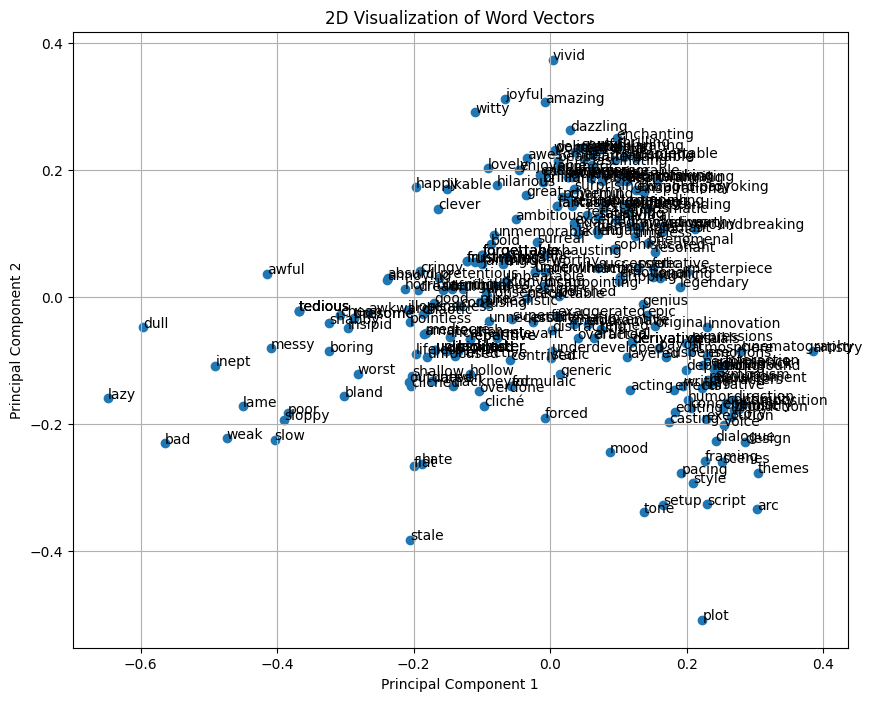

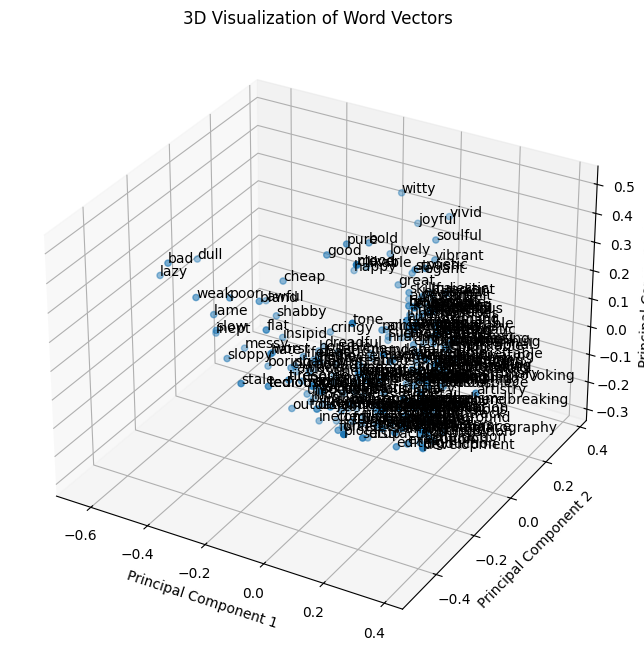

In [ ]:
# For 2D visualization, create a scatter plot and annotate each point with its corresponding word to provide context.
# For 3D visualization, use interactive plotting tools like matplotlib’s Axes3D to explore the spatial relationships between words dynamically.

import matplotlib.pyplot as plt

# 2D scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

# Annotate each point with its corresponding word
for i, word in enumerate(selected_words):
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

plt.title('2D Visualization of Word Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# For 3D visualization (optional)
from mpl_toolkits.mplot3d import Axes3D

# If 3D visualization is needed, use n_components=3 instead
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(word_vec)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the reduced vectors
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], reduced_vectors[:, 2])

# Annotate each point with its corresponding word
for i, word in enumerate(selected_words):
    ax.text(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], word)

ax.set_title('3D Visualization of Word Vectors')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [ ]:
# Examine the resulting visualization for patterns.
# Look for clusters of similar words, such as synonyms or words with similar sentiment,
# Observe the distances between opposite terms.
# Demonstrate how word vectors capture semantic relationships.


The visualization of word vectors provides valuable insights into the semantic relationships between words. In the 2D visualization, positive words (e.g., amazing, joyful, witty, vivid) are clustered together, while negative words (e.g., dull, boring, awful, lazy) form a separate cluster. These groupings demonstrate the model's ability to accurately capture semantic similarities between words. Additionally, there is a clear distance between opposite terms. For example, words like amazing and awful or dull and vivid are positioned far apart, reflecting their semantic opposition. Furthermore, thematically similar words also form distinct groups. For instance, terms related to cinema (plot, acting, tone) are grouped together, as are descriptive adjectives like great, awful, generic.

The 3D visualization allows for a deeper exploration of these relationships. Positive words tend to cluster in higher regions, while negative words occupy lower regions, highlighting how positive and negative sentiments are separated along different axes. Moreover, thematic groups are more distinctly separated in 3D space. For example, adjectives and cinema-related terms exhibit clearer differentiation. This spatial representation reveals the capability of word vectors to capture semantic relationships and oppositions effectively, further validating the model’s context-based association ability.

### 4. Creating the Emebdding Matrix (10 points)

In [ ]:
def create_embedding_matrix(word2vec, vocab, embedding_dim):
    embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
    for word, i in vocabulary.items():
        # Check if the word is in the word2vec model's vocabulary
        if word in word2vec:  # Checking if word is in word2vec model
            embedding_matrix[i] = word2vec[word]
    return embedding_matrix

# Create a matrix where each row corresponds to the vector representation of a word in the vocabulary
# The embedding matrix will have dimensions [vocab_size, embedding_dim], where embedding_dim is the size of the word vectors
embedding_matrix = create_embedding_matrix(fasttext_vectors, all_words, 300)

In [ ]:
import torch
import torch.nn as nn

# Convert the embedding matrix to a PyTorch tensor
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

# Create the embedding layer using the embedding matrix
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix_tensor, freeze=False)

### 5. Implementing the IMDBDataset (5 points)
* Use PyTorch’s Dataset and DataLoader classes to manage the dataset efficiently and create mini-batches for training.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
train_data, test_data, train_label, test_label = train_test_split(data['padded_indices'], data['sentiment'], test_size=0.1, random_state=42)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size=2/9, random_state=42)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 7000
Validation size: 2000
Test size: 1000


In [ ]:
# Implement the dataset class
# Combine the padded sequences and corresponding sentiment labels into a dataset structure compatible with PyTorch.

import torch
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = torch.tensor(self.data[idx], dtype=torch.long)
        label = torch.tensor(self.label[idx], dtype=torch.long)
        return data, label

In [ ]:
from torch.utils.data import DataLoader

# Create Dataset instances
train_dataset = IMDBDataset(train_data.to_list(), train_label.to_list())
val_dataset = IMDBDataset(val_data.to_list(), val_label.to_list())
test_dataset = IMDBDataset(test_data.to_list(), test_label.to_list())

# Create DataLoader instances for each dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Display the first batch of data for verification
for data, labels in train_loader:
    print("First batch of tokens:", data.shape)
    print("First batch of labels:", labels.shape)
    break

First batch of tokens: torch.Size([64, 305])
First batch of labels: torch.Size([64])


### 6. Implementing and Optimizing the Custom LSTM model (40 points)

In [ ]:
# Manually implement the LSTM cell to understand its architecture and functionality.
# Implement forget, input, and output gates.
# Update the cell state and compute the hidden state for each time step.
# Explain your steps and usage of the gates
# Check assignment pdf for more detail on implementation tips

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # Forget gate weights and biases
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)

        # Input gate weights and biases
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)

        # Candidate cell state weights and biases
        self.cell_gate = nn.Linear(input_size + hidden_size, hidden_size)

        # Output gate weights and biases
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        # Concatenate input and previous hidden state
        combined = torch.cat((x_t, h_prev), dim=1)

        # Forget gate
        f_t = torch.sigmoid(self.forget_gate(combined))

        # Input gate
        i_t = torch.sigmoid(self.input_gate(combined))

        # Candidate cell state
        c_tilde = torch.tanh(self.cell_gate(combined))

        # Update cell state
        c_t = f_t * c_prev + i_t * c_tilde

        # Output gate
        o_t = torch.sigmoid(self.output_gate(combined))
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t


In [ ]:
# Build an LSTM layer by combining one or multiple LSTM cells to process a sequence.

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size == 0:
            return torch.empty(0, x.size(1), self.hidden_size, device=x.device) # Return empty tensor if batch size is 0

        seq_len = x.size(1)
        # Ensure h_t and c_t are created on the same device as the input x
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        outputs = []
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t, :], h_t, c_t)
            outputs.append(h_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [ ]:
# Build an LSTM model. Integrate the embedding layer into the model architecture.
# The embedding layer will convert input indices (from padded sequences) into dense word vectors.
# Decide whether to freeze the embedding weights or allow them to be fine-tuned during training and explain your choice.
# These dense vectors are then passed to the LSTM layer for sequential processing.
# You can provide embedding_matrix as tensor to define embedding layer inside the model class
# Or if you have defined embedding layer before, you can directly use that inside the model class

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix.clone().detach(), freeze=False)

        # Custom LSTM Layer
        self.lstm_layer = LSTMLayer(embedding_dim, hidden_size)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out = self.lstm_layer(embedded)
        last_hidden_state = lstm_out[:, -1, :]
        output = self.fc(last_hidden_state)
        return output


In [ ]:
# Define the hyperparameters and try to optimize your model by experimenting with these
vocab_size, embedding_dim = embedding_matrix_tensor.shape
hidden_size = 128
output_size = 1  # Binary classification
epochs = 50
learning_rate = 0.001
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
model = SentimentLSTM(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix_tensor).to(device)

In [ ]:
# Define appropriate loss function for binary classification.
# Choose an optimizer and set its parameters (e.g., learning rate).
# Explain your choice of loss function and optimization algorithm.

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Explanation: BCELoss is suitable for binary classification, and Adam is an adaptive optimizer that helps in fast convergence.

In [ ]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()  # Put the model in training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_loader:
        # Move batch data to GPU
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset optimization
        optimizer.zero_grad()

        # Forward transition
        outputs = model(inputs)

        # Loss calculation
        loss = criterion(outputs.squeeze(), labels.float())

        # Reverse pass and weight update
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        predictions = (outputs.squeeze() > 0.5).float()  # 0.5 threshold value
        correct_preds += (predictions == labels).sum().item()
        total_preds += labels.size(0)

    # Average loss and accuracy
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/50, Loss: 0.6935, Accuracy: 0.4986
Epoch 2/50, Loss: 0.6920, Accuracy: 0.5017
Epoch 3/50, Loss: 0.6724, Accuracy: 0.5234
Epoch 4/50, Loss: 0.6601, Accuracy: 0.5264
Epoch 5/50, Loss: 0.6576, Accuracy: 0.5269
Epoch 6/50, Loss: 0.6584, Accuracy: 0.5267
Epoch 7/50, Loss: 0.6577, Accuracy: 0.5281
Epoch 8/50, Loss: 0.7281, Accuracy: 0.5249
Epoch 9/50, Loss: 0.6779, Accuracy: 0.5254
Epoch 10/50, Loss: 0.6730, Accuracy: 0.5266
Epoch 11/50, Loss: 0.6686, Accuracy: 0.5264
Epoch 12/50, Loss: 0.6677, Accuracy: 0.5269
Epoch 13/50, Loss: 0.6653, Accuracy: 0.5269
Epoch 14/50, Loss: 0.6642, Accuracy: 0.5264
Epoch 15/50, Loss: 0.6643, Accuracy: 0.5269
Epoch 16/50, Loss: 0.6697, Accuracy: 0.5260
Epoch 17/50, Loss: 0.6681, Accuracy: 0.5264
Epoch 18/50, Loss: 0.6635, Accuracy: 0.5264
Epoch 19/50, Loss: 0.6601, Accuracy: 0.5287
Epoch 20/50, Loss: 0.6632, Accuracy: 0.5331
Epoch 21/50, Loss: 0.6609, Accuracy: 0.5319
Epoch 22/50, Loss: 0.6618, Accuracy: 0.5313
Epoch 23/50, Loss: 0.6570, Accuracy: 0.53

In [ ]:
# Validation phase
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0  # Track the best validation accuracy
best_model_state = None  # Save the state of the best model

for epoch in range(epochs):
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            # Accumulate validation loss and accuracy
            val_running_loss += loss.item()
            predictions = (outputs.squeeze() > 0.5).float()
            val_correct_preds += (predictions == labels).sum().item()
            val_total_preds += labels.size(0)

    avg_val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct_preds / val_total_preds
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()

    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the best model after validation
torch.save(best_model_state, "best_model.pth")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

Epoch 1/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 2/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 3/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 4/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 5/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 6/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 7/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 8/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 9/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 10/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 11/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 12/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 13/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 14/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 15/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 16/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 17/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 18/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 19/50, Val Loss: 0.8410, Val Accuracy: 0.8010
Epoch 20/50, Val Loss

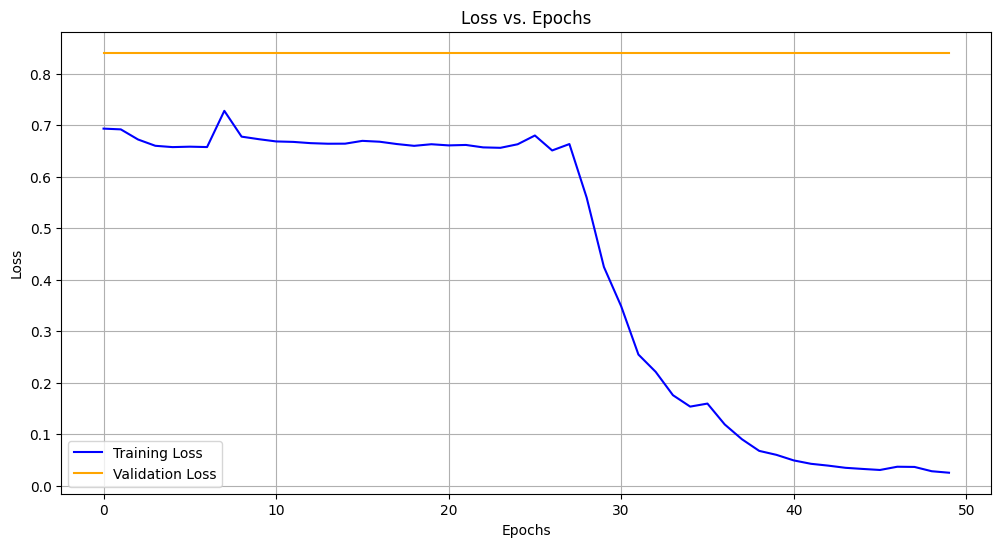

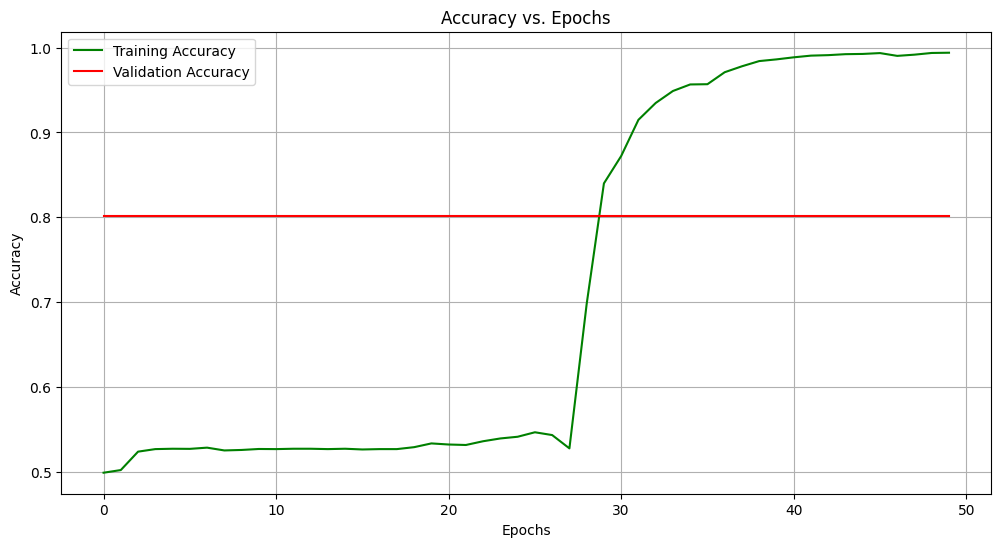

In [ ]:
# Visualize the accuracy and loss change of the best model across training and validation datasets
# Make comments on the results

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='orange')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_accuracies, label='Training Accuracy', color='green')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Throughout the training process, significant changes were observed in the model's accuracy and loss values. Training accuracy initially hovered around 50% with an unstable pattern, but it showed a remarkable improvement starting from the 29th epoch. During this period, training accuracy rapidly increased, reaching 99% by the final epoch. Similarly, training loss steadily decreased from around 0.65 to 0.0249 in the last epoch, indicating that the model successfully learned patterns in the data and was well-optimized.

However, the validation accuracy and loss remained constant throughout all epochs. Validation accuracy was fixed at 80.1%, while validation loss stagnated at 0.8410. This suggests that the model was overfitting, as it performed exceptionally well on the training data but failed to improve on the validation set, highlighting limitations in its generalization ability.

To enhance the model's performance, regularization techniques such as dropout layers or L2 regularization could be applied to mitigate overfitting. Additionally, increasing the size of the dataset, fine-tuning hyperparameters like learning rate, or implementing early stopping based on validation performance could further improve generalization and overall effectiveness.

### 7. Testing and Analysis (15 points)

In [ ]:
# Test the best model on the test set to evaluate its performance.
# Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
# Explain and analyze your findings and results.
# Summarize the performance of the model on the training, validation and test set. Comment on the results.
# Discuss any challenges encountered during training and potential areas for improvement.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the best model state
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set the model to evaluation mode

# Test the model on the test set
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predictions = (outputs.squeeze() > 0.5).float()
        test_preds.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Compute metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

<ipython-input-34-b7dc4fc7b85b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 0.7970
Test Precision: 0.7980
Test Recall: 0.7899
Test F1-Score: 0.7939


The model's test performance shows an accuracy of 79.7%, with precision at 79.8%, recall at 78.99%, and an F1-score of 79.39%. These metrics indicate balanced performance in classifying positive and negative reviews, with precision slightly outperforming recall. The consistency between validation accuracy (80.1%) and test accuracy suggests the model generalizes well to unseen data, though the gap between training and test accuracy highlights potential overfitting.

To improve, regularization techniques, data augmentation, or hyperparameter optimization could be applied. Despite its strong performance, addressing these areas could enhance the model’s ability to generalize further and achieve higher accuracy and recall.

#### Comparison with the Pytorch LSTM model (Optional)

In [ ]:
# Implement sentiment LSTM model using PyTorch's built-in LSTM layer
# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class PyTorchLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, embedding_matrix):
        super(PyTorchLSTM, self).__init__()
        # Define embedding layer with pre-trained embeddings
        self.embedding =
        # Use PyTorch's built-in LSTM layer
        self.lstm =
        # Fully connected layer for binary classification
        self.fc =
        # Sigmoid activation
        self.sigmoid =

    def forward(self, x):
        # Convert word indices to word vectors
        # LSTM processing
        # Use the last hidden state
        # Pass through the sigmoid
        return output


In [ ]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance

In [ ]:
# Define parameters
# Define criterion and optimizer
# Train PyTorch LSTM model

In [ ]:
# Compare the performance of your custom LSTM model with PyTorchLSTM model